In [1]:
from typing import Type, Any, Dict, Iterable, Callable, Union, List
import torch
from torch.utils.data import TensorDataset, DataLoader
from bitlinear.bitlinear import BitLinear
from bitlinear.adapters import LoRAAdapter, MergeableLayer
from torch.optim import Adam, Optimizer
from torch.optim.lr_scheduler import LambdaLR
import gc

In [2]:
import matplotlib.pyplot as plt

In [3]:
x_orig = torch.Tensor([
    [0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [1, 0, 0, 0, 0],
    [1, 1, 0, 0, 0],
])
y_orig = torch.FloatTensor([
    [0],
    [1],
    [1],
    [0],
])
x = []
y = []
for i in range(500000):
    x.append(x_orig + torch.rand(size=x_orig.shape) * 0.2 - 0.1)
    y.append(y_orig)
x = torch.cat(x, dim=0)
y = torch.cat(y, dim=0)
dataset = TensorDataset(x, y)

In [4]:
class ReLoRAOptimizer(Optimizer):
    def __init__(self,
                 params: Iterable[torch.Tensor] | Iterable[Dict[str, Any]],
                 mergeable_layers: Iterable[MergeableLayer],
                 optimizer_cls: Type[Optimizer],
                 optimizer_params: Dict[str, Any],
                 reset_n_steps: int,
                 lr: float = 1e-3,) -> None:
        params_list = list(params)
        self.inner_params = params_list
        self.optimizer_cls = optimizer_cls
        self.optimizer_params = optimizer_params
        self.lr = lr
        
        # Some trickery around param_groups require me to re-initialize stuff
        self.optimizer = self._initialize_optimizer()
        super(ReLoRAOptimizer, self).__init__(params_list, {})
        self.optimizer = self._initialize_optimizer()
        gc.collect()

        self.mergeable_layers = mergeable_layers
        self.reset_n_steps = reset_n_steps
        self.made_steps = 0

    def _initialize_optimizer(self) -> Optimizer:
        params = dict(lr=self.lr, **self.optimizer_params)
        return self.optimizer_cls(self.inner_params, **params)
    
    def step(self) -> None:
        if self.made_steps % self.reset_n_steps == 0:
            if self.made_steps != 0:
                for layer in self.mergeable_layers:
                    layer.merge_adapter()
            self.optimizer = self._initialize_optimizer()
            gc.collect()
        self.optimizer.step()
        self.made_steps += 1

    @property
    def param_groups(self):
        groups = []
        for group in self.optimizer.param_groups:
            if 'lr' not in group:
                group['lr'] = self.lr
            groups.append(group)
        return groups
    
    @param_groups.setter
    def param_groups(self, groups):
        self.optimizer.param_groups = groups

    def state_dict(self) -> Dict[str, Any]:
        return self.optimizer.state_dict()
    
    def load_state_dict(self, state_dict: Dict[str, Any]) -> None:
        return self.optimizer.load_state_dict(state_dict)

In [5]:
class ReLoRASchedulerLambda:
    def __init__(self, lr_lambda: callable, reset_n_steps: int, warmup_n_steps: int):
        self.func = self._wrap_lr_lambda(lr_lambda)
        self.reset_n_steps = reset_n_steps
        self.warmup_n_steps = warmup_n_steps
    
    def __call__(self, *args: Any, **kwargs: Any) -> Any:
        return self.func(*args, **kwargs)
    
    def _wrap_lr_lambda(self, func):
        def _func(step):
            if step % self.reset_n_steps < self.warmup_n_steps:
                k = (step % self.reset_n_steps) / self.warmup_n_steps
            else:
                k = 1
            value = func(step) * k
            return value
        
        return _func

In [6]:
def linear_warmup_schedule(warmup_steps, all_steps):
    def _func(step):
        if step < warmup_steps:
            return step / warmup_steps
        else:
            return 1.0 - (step - warmup_steps) / (all_steps - warmup_steps)
    
    return _func

In [7]:
def test_training(device):
    dataloader = DataLoader(dataset, batch_size=100)
    dataloader_iter = iter(dataloader)

    lora_0 = LoRAAdapter(
        in_features=5,
        out_features=10,
        lora_rank=2,
        device=device,
    )
    lora_1 = LoRAAdapter(
        in_features=10,
        out_features=1,
        lora_rank=2,
        device=device,
    )
    layer_0 = BitLinear(
        in_features=5,
        out_features=10,
        bias=True,
        device=device,
        original_weights_filename="test-relora-layer-0.bin",
        adapter=lora_0,
    )
    layer_1 = BitLinear(
        in_features=10,
        out_features=1,
        device=device,
        original_weights_filename="test-relora-layer-1.bin",
        adapter=lora_1,
    )
    network = torch.nn.Sequential(
        layer_0,
        torch.nn.GELU(),
        layer_1,
        torch.nn.Sigmoid()
    )
    loss = torch.nn.BCELoss()

    losses = []
    optimizer = ReLoRAOptimizer(
        network.parameters(),
        mergeable_layers=[
            layer_0, layer_1,
        ],
        optimizer_cls=Adam,
        optimizer_params={},
        reset_n_steps=250,
        lr=1e-3,
    )
    lr_scheduler = LambdaLR(
        optimizer,
        ReLoRASchedulerLambda(
            linear_warmup_schedule(250, 5000),
            reset_n_steps=250,
            warmup_n_steps=25,
        ),
    )
    network.train()
    lrs = []
    for _ in range(5000):
        optimizer.zero_grad()
        batch = next(dataloader_iter)
        x, y = batch
        y_pred = network(x.to(device))
        loss_value = loss(y_pred, y.to(device))
        loss_value.backward()
        losses.append(loss_value.item())
        optimizer.step()
        lr_scheduler.step()
        lr = optimizer.state_dict()['param_groups'][0]['lr']
        lrs.append(lr)

    plt.plot(losses)
    plt.ylabel("Loss")
    plt.xlabel("Steps")
    plt.title("1.5bit ReLoRA XOR loss")
    plt.grid()
    plt.show()

    plt.plot(lrs)
    plt.ylabel("LR")
    plt.xlabel("Steps")
    plt.title("1.5bit ReLoRA XOR LR")
    plt.grid()
    plt.show()

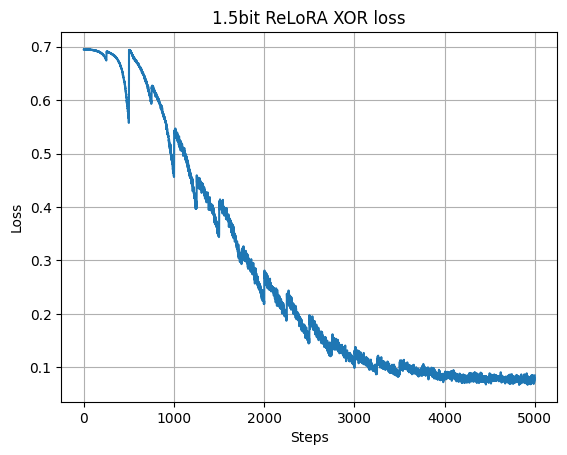

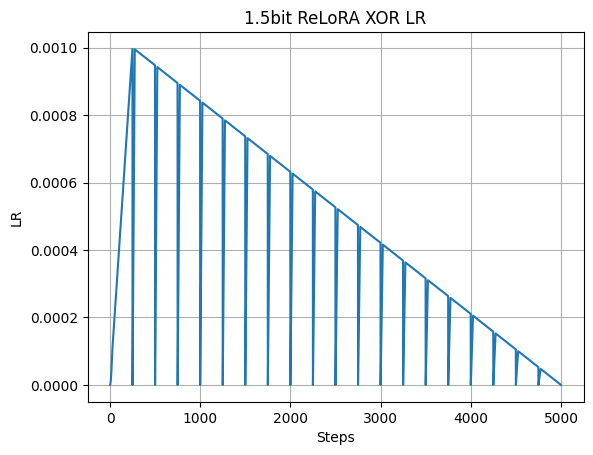

In [8]:
test_training("cpu")

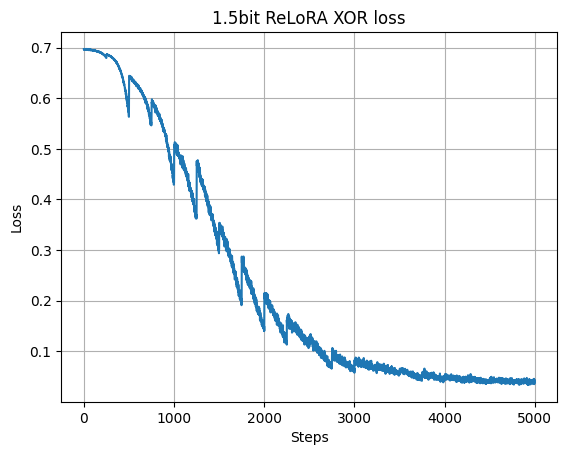

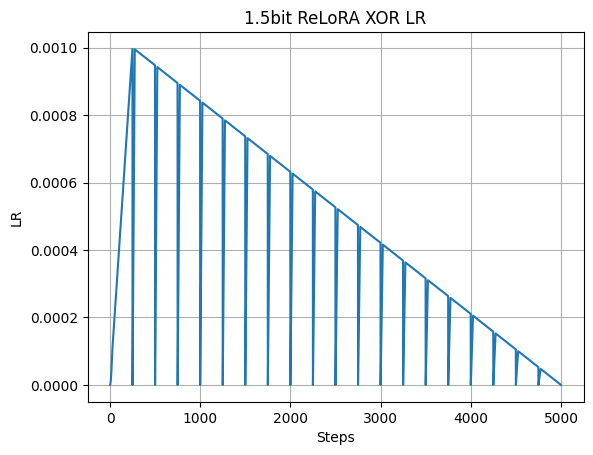

In [9]:
test_training("cuda:0")